# Students

- Sarah Blanc - 5854830
- Allan Guzmán Fallas - 5718619
- Simon Scherders - 5878845

# Libraries

In [125]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import re 
from geopy.distance import geodesic
from datetime import datetime, timedelta, time, date
import matplotlib.pyplot as plt
# Part 2 (IFAM model)

In [126]:
# group_number gn 
gn = '4'

# Inputs

In [127]:
# Define the inputs

# L: set of flights
flights_df = pd.read_excel('Assignment_Data/Part_2/Group_'+gn+'_P2.xlsx', sheet_name='Flight')
#change data type of colum 'Flight no.' ro string
flights_df['Flight Number'] = flights_df['Flight Number'].astype(str)
flights_list = flights_df['Flight Number'].to_list() 

# P: set of passenger itineraries
paths = pd.read_excel('Assignment_Data/Part_2/Group_'+gn+'_P2.xlsx', sheet_name='Itinerary').set_index('Itin No.')

# P_p: set of passenger itineraries with Recapture Rate from itinerary p
recapture_p = pd.read_excel('Assignment_Data/Part_2/Group_'+gn+'_P2.xlsx', sheet_name='Recapture Rate').set_index(['From Itinerary','To Itinerary'])
recapture_p.rename(columns={'From Itinerary': 'p', 'To Itinerary': 'r'}, inplace=True)

# K: set of aircraft types
aircraft_df = pd.read_excel('Assignment_Data/Part_2/Group_'+gn+'_P2.xlsx', sheet_name='Aircraft')
aircraft_df.rename(columns={'Type': 'AC Type'}, inplace=True)
aircraft_df.set_index('AC Type', inplace=True)
aircraft = aircraft_df.to_dict(orient='index')
ac_list = list(aircraft.keys())

# make a dictionary with the itinerary as the key and the rest as a sub-dictionary
paths['Leg 1'] = paths['Leg 1'].astype(str)
paths['Leg 2'] = paths['Leg 2'].astype(str)

paths = paths.to_dict(orient='index')
path_list = list(paths.keys())

# flights = flights_df.to_dict(orient='index')
recapture_p = recapture_p.to_dict(orient='index')

# Drop the inner dicts and just keep the values of the inner dict
for key in recapture_p:
    recapture_p[key] = recapture_p[key]['Recapture Rate']

# For all paths if 'Leg 1' and 'Leg 2' are numbers then create a list with both legs else, drop the keys from the list, and create a new key called 'Legs'
# else just change the name of the key 'Leg 1' to 'Legs'
for key in path_list:
    legs = []
    if paths[key]['Leg 1'] != '0' and paths[key]['Leg 2'] != '0':
        legs.append(paths[key]['Leg 1'])
        legs.append(paths[key]['Leg 2'])
        paths[key]['Legs'] = legs
    elif paths[key]['Leg 1'] != '0':
        legs.append(paths[key]['Leg 1'])
        paths[key]['Legs'] = legs
    del paths[key]['Leg 1']
    del paths[key]['Leg 2']

# Define path 999 with a fare of 0 and a demand of 0 
paths[999] = {'Legs': [], 'Demand': 0, 'Fare': 0}

for k in aircraft:
    aircraft[k]['TAT'] = timedelta(minutes=aircraft[k]['TAT'])

flights = flights_df.merge(aircraft_df.reset_index()[['AC Type']], how='cross')

In [128]:
# Get the cost from the column named after the AC Type
flights['Cost'] = flights.apply(lambda row: row[row['AC Type']], axis=1)
flights.drop(columns=ac_list, inplace=True)

# Get the capacity from the dictionary
flights['Capacity'] = flights.apply(lambda row: aircraft[row['AC Type']]['Seats'], axis=1)

In [129]:
# List of unique airports from Origin and Destination columns
airports = list(set(flights['ORG'].unique()).union(set(flights['DEST'].unique())))

In [130]:
# Misc date just for adding the TAT
misc_date = date(1,1,1)

# Drop rows with distance > range
flights['Arrival'] = flights.apply(lambda row: (datetime.combine(misc_date,row['Arrival']) + aircraft[row['AC Type']]['TAT']).time(), axis=1)
flights['Overnight'] = flights.apply(lambda row: row['Arrival'] < row['Departure'], axis=1)
# Make flights dictionary with main keys: AC Type, with a sub dictionary of flight numbers and each with flight details
flights_dict = {}
for i in flights_list:
    flights_dict[i] = flights[flights['Flight Number'] == i].set_index('AC Type').to_dict(orient='index')

flights = flights_dict

In [131]:
# Create an empty list to store the data
data = []
# Iterate over airports, aircraft types, and flights
for l in flights:
    for k in flights[l]:
            for n in airports:
                if flights[l][k]['ORG'] == n:
                    data.append([k, n, l, flights[l][k]['Departure'], 'Departure'])
                if flights[l][k]['DEST'] == n:
                    data.append([k, n, l, flights[l][k]['Arrival'], 'Arrival'])

# Create a dataframe with the data
events = pd.DataFrame(data, columns=['AC Type','Airport', 'Flight N', 'Time', 'D_A'])

# Add the TAT to the arrival times

events.sort_values(by=['AC Type', 'Airport', 'Time'], inplace=True)

# Reset the numbering of the events
events.reset_index(drop=True, inplace=True)

In [132]:
# For each airport and aircraft type i need to create a loop of ground arcs, each starting from the last event and ending at the next event, if there is no more events then the last ground arc is the overnight arc and it ends at the first event of the next day (first event of the next day is the first event of the same airport and aircraft type)

ground_arcs = pd.DataFrame(columns=['AC Type', 'Airport', 'Start Time', 'End Time'])

for k in ac_list:
    for n in airports:
        df = events[(events['AC Type'] == k) & (events['Airport'] == n)].sort_values(by=['Time'])
        for i in range(len(df)):
            if i == 0:
                ground_arcs = pd.concat([ground_arcs, pd.DataFrame({'AC Type': k, 'Airport': n, 'Start Time': [df.iloc[-1]['Time']], 'End Time': [df.iloc[i]['Time']]})], ignore_index=True)
            else:
                ground_arcs = pd.concat([ground_arcs, pd.DataFrame({'AC Type': k, 'Airport': n, 'Start Time': [df.iloc[i-1]['Time']], 'End Time': [df.iloc[i]['Time']]})], ignore_index=True)

ground_arcs.sort_values(by=['AC Type', 'Airport'], inplace=True)
# Drop rows if start time and end time are the same
ground_arcs = ground_arcs[~ground_arcs.apply(lambda row: (row['Start Time'] == row['End Time']), axis=1)]
ground_arcs['Arc ID'] = ground_arcs.groupby(['AC Type', 'Airport']).cumcount()
ground_arcs['Arc ID'] = ground_arcs.apply(lambda row: str(str(row['Arc ID']) + '_' + str(row['Airport'])) , axis=1)
ground_arcs['Overnight'] = ground_arcs.apply(lambda row: (row['End Time'] < row['Start Time']), axis=1)

In [133]:
# Create a nodes_df
nodes_df = ground_arcs[['AC Type', 'Airport', 'Start Time']].rename(columns={'Start Time': 'Time'})

# Add a count number for each row group by AC Type and Airport
nodes_df['Node ID'] = nodes_df.groupby(['AC Type','Airport']).cumcount()

# make a dictionary with the ac type as main key and the airport as secondary key with the node as tertiary key and the time as value
nodes = {}
for k in ac_list:
    nodes[k] = {}
    for n in airports:
        nodes[k][n] = {}
        for i in nodes_df[(nodes_df['AC Type'] == k) & (nodes_df['Airport'] == n)]['Node ID']:
            nodes[k][n][i] = {'Time': nodes_df[(nodes_df['AC Type'] == k) & 
                                               (nodes_df['Airport'] == n) & 
                                               (nodes_df['Node ID'] == i)]['Time'].values[0]}
            

In [134]:
# Add node id to the events
events.merge(nodes_df, how='left', on=['AC Type', 'Airport', 'Time']).sort_values(by=['AC Type', 'Airport'])

# Add a dictionary call departures and another one arrivals to the nodes dictionary at k,n,i+1 with 
# the events that have the same ac type, airport and time as the node
for k in ac_list:
    for n in airports:
        for i in nodes_df[(nodes_df['AC Type'] == k) & (nodes_df['Airport'] == n)]['Node ID']:
            nodes[k][n][i]['Departures'] = list(events[(events['AC Type'] == k) & (events['Airport'] == n) & (events['Time'] == nodes[k][n][i]['Time']) & (events['D_A'] == 'Departure')]['Flight N'])
            nodes[k][n][i]['Arrivals'] = list(events[(events['AC Type'] == k) & (events['Airport'] == n) & (events['Time'] == nodes[k][n][i]['Time']) & (events['D_A'] == 'Arrival')]['Flight N'])


In [135]:
# n+: ground arcs originating at any node n (start time)
# n-: ground arcs ending at any node n (end time)
n_plus = ground_arcs[['Airport', 'AC Type', 'Start Time', 'Arc ID']].rename(columns={'Start Time': 'Time'})
n_minus = ground_arcs[['Airport', 'AC Type', 'End Time', 'Arc ID']].rename(columns={'End Time': 'Time'})

# Add a dictionary call n+ and another one n- to the nodes dictionary at k,n,i+1 with 
# the events that have the same ac type, airport and time as the node
for k in ac_list:
    for n in airports:
        for i in nodes_df[(nodes_df['AC Type'] == k) & (nodes_df['Airport'] == n)]['Node ID']:
            nodes[k][n][i]['n+'] = list(n_plus[(n_plus['AC Type'] == k) & (n_plus['Airport'] == n) & (n_plus['Time'] == nodes[k][n][i]['Time'])]['Arc ID'])
            nodes[k][n][i]['n-'] = list(n_minus[(n_minus['AC Type'] == k) & (n_minus['Airport'] == n) & (n_minus['Time'] == nodes[k][n][i]['Time'])]['Arc ID'])

In [158]:
overnight_arcs = ground_arcs[ground_arcs['Overnight'] == True][['AC Type', 'Airport', 'Arc ID']]
overnight_flights = []
for l in flights:
    for k in flights[l]:
        if flights[l][k]['Overnight']:
            overnight_flights.append([k, l])

overnight_flights = pd.DataFrame(overnight_flights, columns=['AC Type', 'Flight no.'])

In [137]:
# s_ip: binary variable indicating whether flight i is in itinerary p
s_ip = {}
for i in flights_list:
    for p in paths:
        s_ip[i,999] = 0
        if i in paths[p]['Legs']:
            s_ip[i,p] = 1
        else:
            s_ip[i,p] = 0

# Q_i: unconstrained demand for flight i = sum s_ip * demand of itinerary p for p in P
Q_i = {}
for i in flights_list:
    Q_i[i] = 0
    for p in paths:
        Q_i[i] += s_ip[i,p] * paths[p]['Demand']

In [138]:
path_list = list(paths.keys())
flight_list = list(flights.keys())

In [139]:
# Add entries to P_p for path 0 with a Recapture Rate of 1
for p in paths:
    recapture_p[p,999] = 1
    recapture_p[999,p] = 0

In [140]:
ploting = False
if ploting:
    import random
    import plotly.graph_objects as go

    for k in ac_list:
        df = events[events['AC Type'] == k].sort_values(by=['Time'])
        fig = go.Figure()
        
        # make the figure taller to fit all airports
        fig.update_layout(
            autosize=False,
            width=1000,
            height=1000,
        )
        
        # Set marker color based on 'D_A' column
        marker_color = ['red' if d_a == 'Departure' else 'blue' for d_a in df['D_A']]
        
        # Add ground arcs
        ground_arcs_k = ground_arcs[ground_arcs['AC Type'] == k]
        for i, row in ground_arcs_k.iterrows():
            # Generate a random color
            random_color = '#' + ''.join(random.choices('0123456789ABCDEF', k=6))
            fig.add_shape(
                type="line",
                x0=row['Start Time'],
                y0=row['Airport'],
                x1=row['End Time'],
                y1=row['Airport'],
                line=dict(color=random_color, width=2)
            )
        
        fig.add_trace(go.Scatter(
            x=df['Time'], 
            y=df['Airport'], 
            mode='markers+text',
            marker=dict(color=marker_color),
            hovertemplate= '<b>Flight no.</b>: ' + df['Flight N'] + '<br>' ))
        
        
        fig.update_layout(
            title="Ground Arcs for AC Type " + k,
            xaxis_title="Time",
            yaxis_title="Airport",
        )
        fig.show()


In [141]:
# for each path p, key-value pair in initial pairs with key p and value 999 in a set
initial_pairs = {}
for p in path_list:
    initial_pairs[p] = set()
    initial_pairs[p].add(999)

In [142]:
# Notation

L = flights
P = paths
P0 = initial_pairs
K = ac_list
G = nodes
N = airports
Q = Q_i
R = recapture_p
Gr = ground_arcs


# Iterative model

In [143]:
def PMF_n_iters(
        n_iters, pairs, # required inputs
        pi = {}, sigma= {}, P=P, L=L, 
        R=R, iter=0, prev_model = {}): # optional inputs
    
    if iter == 0:
        print('Base model: all itineraries to ficticious (999)')
        C = {k: set(v) for k, v in pairs.items()} # current pairs

    if iter > 0:
        print('Iteration number: ', iter, '\n')
        C = {k: set(v) for k, v in pairs.items()} # current pairs
        tpr_prime = {}
        # tpr = (fare_p - sum (π_i) for i being each flight in path p) - bpr * (fare_r - sum (π_j) for j being each flight in path p)) - σ_p
        print('Negative slack pairs: ')
        for p,r in R.keys():
            t_prime_pr = ((P[p]['Fare'] - sum(pi[i] for i in P[p]['Legs'])) -
                            (R[(p,r)]) *
                            (P[r]['Fare'] - sum(pi[j] for j in P[r]['Legs'])) -
                            (sigma[p]))
            if t_prime_pr < -0.0001:
                tpr_prime[p,r] = t_prime_pr
                print(str(p)+' -> '+str(r)+': ', t_prime_pr)
                
        pairs = list(tpr_prime.keys())
        
        for n_p in pairs:
            C[n_p[0]].add(n_p[1])


    if len(pairs) == 0:
        print('No new pairs, optimal solution found in previous iteration')
        return C, pi, sigma, prev_model
    
    if len(pairs) > 0:
        if iter != 0:
            print('New pairs: ', pairs, '\n')

        # Define the model
        m_n = gp.Model('IFAM')

        ''' 
        Notation
        P = paths with info on O, D, Demand, Fare, Legs
        L = flights list with info on AC Type, ORG, DEST, Departure, Arrival, Overnight, Capacity, Cost
        P0 = initial_pairs with key-value pair in initial pairs with key p and value 999 in a set
        K = Types of aircraft
        G = nodes with info on Node ID, AC Type, Airport, Time, Departures, Arrivals, n+, n-
        N = airports list
        Q = Q_i = unconstrained demand for flight i = sum s_ip * demand of itinerary p for p in P
        R = recapture_p = set of passenger itineraries with Recapture Rate from itinerary p
        Gr = ground_arcs with info on AC Type, Airport, Start Time, End Time, Arc ID, Overnight
        C = current pairs
        '''

        # Decision variables from FAM
        # f[i,k] [RELAXED] binary 1 if flight arc i is assigned to aircraft type k, 0 otherwise
        f = {}
        # y_ak = [RELAXED] integer number of aircraft of type k on the ground arc a
        y = {}

        for i in L:
            for k in K:
                f[i, k] = m_n.addVar(vtype=GRB.CONTINUOUS, name='f_' + str(i) + '_' + str(k))

        for k in K:
            for a in list(ground_arcs[(ground_arcs['AC Type'] == k)]['Arc ID']):
                y[a, k] = m_n.addVar(vtype=GRB.CONTINUOUS,lb=0, name='y_' + str(a) + '_' + str(k))

        # Decision variables from PMF
        # t_pr: number of passengers that would like to fly on itinerary p and are reallocated to itinerary r
        t = {}

        for p in C:
            for r in C[p]:
                t[p,r] = m_n.addVar(vtype=GRB.CONTINUOUS,lb=0,name='t_'+str(p)+'_'+str(r))
        m_n.update()

        # Objective function part from the FAM
        of = gp.quicksum(
            L[i][k]['Cost'] * 
            f[i,k] 
            for i in L for k in K)

        # Objective function part from the PMF
        of +=  gp.quicksum((P[p]['Fare'] - R[(p,r)] * P[r]['Fare']) * t[p,r] 
                        for p in C for r in C[p])

        # Define the objective function
        m_n.setObjective(of, GRB.MINIMIZE)

        # Define the constraints
        # Constraint 1 [FAM]: 
        # Each flight is assigned to exactly one aircraft type
        for i in L:
            m_n.addConstr((gp.quicksum(f[i,k] for k in K) == 1), name='one_ac' + str(i))

        # Constraint 2 [FAM]: 
        # The number of AC arriving = AC departing, for each type at each node
        # y_n+_k + sum(f_i,k) = y_n-_k + sum(f_i,k)
        for k in K:
            for n in airports:
                for i in nodes[k][n]:
                    m_n.addConstr((y[nodes[k][n][i]['n+'][0], k] + gp.quicksum(f[w,k] for w in nodes[k][n][i]['Departures']) == 
                                y[nodes[k][n][i]['n-'][0], k] + gp.quicksum(f[w,k] for w in nodes[k][n][i]['Arrivals']) ),
                                name='balance_' + str(i) + '_' + str(k) + '_' + str(n))

        # Constraint 3 [FAM]: 
        # The number of overnight arcs + the number of overnight flights = the number of aircraft of each type 
        # using overnight_arcs and overnight_flights
        # sum(y_a,k) + sum(f_i,k) = number of aircraft of type k
        for k in K:
            m_n.addConstr((gp.quicksum(y[a, k] for a in list(overnight_arcs[(overnight_arcs['AC Type'] == k)]['Arc ID'])) + 
                        gp.quicksum(f[i, k] for i in list(overnight_flights[(overnight_flights['AC Type'] == k)]['Flight no.'])) <= 
                        aircraft[k]['Units']), name='overnight_' + str(k))

        # Constraint 4 [MIXED]: 
        # removed (from flight i in path p) - recaptured (for flight i in path p) ≥ demand spillage (for flight i) - capacity (for flight i) assinged to aircraft type k
        # sum seats_k * f_ik -sum s_ip * t_pr - sum sum s_ip * brp * t_rp >= ds_i for all i but for r = 0 
        m_n.addConstrs((
            gp.quicksum(aircraft[k]['Seats'] * f[i,k] for k in K) +
            gp.quicksum(s_ip[i,p] * t[p,r] for p in C for r in C[p]) - 
            gp.quicksum(s_ip[i,r] * R[(p,r)] * t[p,r] for p in C for r in C[p]) >= 
            Q[i] for i in L), name='π')

        # Constraint 5 [PMF]: sum t_pr <= Dp for all p
        for p in C:
            m_n.addConstr((
                gp.quicksum(t[p,r] for r in C[p]) <= P[p]['Demand']), name='σ[' + str(p) + ']')

        # Update the model
        m_n.update()
        # Optimize the model but dont print the output
        m_n.setParam('OutputFlag', 0)
        m_n.optimize()
        print('Objective value: %0.0f' % (m_n.objVal), '\n')
        #m_n.write('IFAM'+str(iter)+'.lp')

        # Print the total runtime of the model
        print('Total runtime: %0.2f' % (m_n.Runtime), '\n')

        # Print the first 5 t decision variables
        print('Non-Null Flight variables:')
        it_t = 0
        it_f = 0
        for v in m_n.getVars():
            if v.X != 0 and v.VarName[0] == 't' and it_t < 5:
                print('%s = %g' % (v.VarName, v.X))
                it_t += 1
                
        for v in m_n.getVars():
            if v.X != 0 and v.VarName[0] == 'f' and it_f < 5:
                print('%s = %g' % (v.VarName, v.X))
                it_f += 1
        print('\n')
                

        print('Non-Null Dual variables:')
        it_pi= 0
        it_sigma = 0
        for c in m_n.getConstrs():
            if c.Pi != 0 and it_pi < 5 and c.constrName[0] == 'π':
                print('%s = %g' % (c.ConstrName, c.Pi))
                it_pi += 1
            if c.Pi != 0 and it_sigma < 5 and c.constrName[0] == 'σ':
                print('%s = %g' % (c.ConstrName, c.Pi))
                it_sigma += 1


        # Save dual variables in a dictionary
        pi_new = {}
        for c in m_n.getConstrs():
            if c.constrName[0] == 'π':
                flight_num_pi = c.ConstrName[2:-1]
                pi_new[flight_num_pi] = c.Pi

        sigma_new = {}
        for c in m_n.getConstrs():
            if c.constrName[0] == 'σ':
                path_num_sigma = int(re.findall(r'\d+', c.ConstrName)[0])    
                sigma_new[path_num_sigma] = c.Pi

        if iter == 0:
            print ('End of base model iteration\n')
        else:
            print('End of iteration number: ', iter, '\n')
        
        iter += 1

        if iter == n_iters:
            print('Max number of iterations reached')
            return C, pi_new, sigma_new, m_n
        else:
            return  PMF_n_iters(
                    n_iters,
                    C,
                    sigma = sigma_new, 
                    pi= pi_new,
                    iter=iter,
                    prev_model=m_n)

In [144]:
final_pairs, final_pi, final_sigma, modelito = PMF_n_iters(2, initial_pairs)

Base model: all itineraries to ficticious (999)
Objective value: 5490758 

Total runtime: 0.03 

Non-Null Flight variables:
t_9_999 = 15
t_19_999 = 26
t_34_999 = 7
t_37_999 = 22
t_47_999 = 30
f_AR1132_A330 = 1
f_AR1133_A330 = 1
f_AR1140_B737 = 1
f_AR1160_B738 = 1
f_AR1161_B738 = 1


Non-Null Dual variables:
π[AR1133] = 57
π[AR1240] = 241
π[AR1241] = 288.235
π[AR1248] = 173
π[AR1249] = 47
σ[9] = -142
σ[19] = -145
σ[37] = -136
σ[47] = -2
σ[48] = -121
End of base model iteration

Iteration number:  1 

Negative slack pairs: 
115 -> 120:  -1.75
117 -> 120:  -1.6500000000000004
122 -> 68:  -4.96
133 -> 163:  -0.39
134 -> 164:  -0.33999999999999986
156 -> 158:  -5.3999999999999995
176 -> 173:  -1.98
338 -> 279:  -21.56
367 -> 285:  -16.38
376 -> 291:  -21.85
New pairs:  [(115, 120), (117, 120), (122, 68), (133, 163), (134, 164), (156, 158), (176, 173), (338, 279), (367, 285), (376, 291)] 

Objective value: 5490111 

Total runtime: 0.03 

Non-Null Flight variables:
t_9_999 = 15
t_19_999 = 26


# Final model

In [145]:
# Define the model
m = gp.Model('IFAM')

# Notation
# P = paths with info on O, D, Demand, Fare, Legs
# L = flights_list
# P0 = initial_pairs
# K = ac_list
# G = nodes
# N = airports
# Q = Q_i
# R = recapture_p


# Decision variables from FAM
# f[i,k] binary 1 if flight arc i is assigned to aircraft type k, 0 otherwise
f = {}
# y_ak = integer number of aircraft of type k on the ground arc a
y = {}

for i in L:
    for k in K:
        f[i, k] = m.addVar(vtype=GRB.BINARY, name='f_' + str(i) + '_' + str(k))

for k in K:
    for a in list(ground_arcs[(ground_arcs['AC Type'] == k)]['Arc ID']):
        y[a, k] = m.addVar(vtype=GRB.INTEGER,lb=0, name='y_' + str(a) + '_' + str(k))

# Decision variables from PMF
# t_pr: number of passengers that would like to fly on itinerary p and are reallocated to itinerary r
t = {}

for p in final_pairs:
    for r in final_pairs[p]:
        t[p,r] = m.addVar(vtype=GRB.INTEGER,lb=0,name='t_'+str(p)+'_'+str(r))
m.update()

# Objective function part from the FAM
of = gp.quicksum(flights[i][k]['Cost'] * f[i,k] for i in L for k in K) + \
     gp.quicksum((P[p]['Fare'] - R[(p,r)] * P[r]['Fare']) * t[p,r] for p in final_pairs for r in final_pairs[p])

# Define the objective function
m.setObjective(of, GRB.MINIMIZE)

# Define the constraints from the FAM
# Constraint 1 [FAM]: 
# Each flight is assigned to exactly one aircraft type
m.addConstrs((gp.quicksum(f[i,k] for k in K) == 1 for i in L), name='one_ac')

# Constraint 2 [FAM]: 
# The number of AC arriving (n+ and arrivals) = AC departing yn-, for each type at each node
# y_n+_k + sum(f_i,k) = y_n-_k + sum(f_i,k)
for k in K:
    for n in N:
        for i in G[k][n]:
            n_plus = y[G[k][n][i]['n+'][0], k]
            n_minus = y[G[k][n][i]['n-'][0], k]
            departures = gp.quicksum(f[w,k] for w in G[k][n][i]['Departures'])
            arrivals = gp.quicksum(f[w,k] for w in G[k][n][i]['Arrivals'])
            m.addConstr((n_plus + departures - n_minus - arrivals == 0),
                         name='balance_' + str(i) + '_' + str(k) + '_' + str(n))

# Constraint 3 [FAM]: 
# The number of overnight arcs + the number of overnight flights = the number of aircraft of each type 
# using overnight_arcs and overnight_flights
# sum(y_a,k) + sum(f_i,k) = number of aircraft of type k
for k in K:
    m.addConstr((gp.quicksum(y[a, k] for a in list(overnight_arcs[(overnight_arcs['AC Type'] == k)]['Arc ID'])) + 
                 gp.quicksum(f[i, k] for i in list(overnight_flights[(overnight_flights['AC Type'] == k)]['Flight no.'])) <= 
                 aircraft[k]['Units']), name='overnight_' + str(k))

# Constraint 4 [MIXED]: 
# Aircraft capacity constraint
# sum seats_k * f_ik -sum s_ip * t_pr - sum sum s_ip * brp * t_rp >= ds_i for all i but for r = 0 
m.addConstrs((gp.quicksum(aircraft[k]['Seats'] * f[i,k] for k in K) +
              gp.quicksum(s_ip[i,p] * t[p,r] for p in final_pairs for r in final_pairs[p]) - 
              gp.quicksum(s_ip[i,r] * R[(p,r)] * t[p,r] for p in final_pairs for r in final_pairs[p]) >= 
              Q[i] for i in L), name='π')

# Constraint 5 [PMF]: sum t_pr <= Dp for all p
for p in P:
    m.addConstr((
        gp.quicksum(t[p,r] for r in final_pairs[p]) <= P[p]['Demand']), name='σ[' + str(p) + ']')

# Update the model
m.update()
# Optimize the model but dont print the output
m.setParam('OutputFlag', 0)
m.optimize()
print('Objective value: %0.0f euros' % (m.objVal))

# Print the total runtime of the model
print('Total runtime: %0.2f seconds' % (m.Runtime))

Objective value: 6460718 euros
Total runtime: 0.14 seconds


# Output testing

In [146]:
for w in ac_list:
    print('Flights for AC Type ' + w)
    for i in flights_list:
        for k in ac_list:
            if f[i,k].x > 0.00001 and k == w:
                print(i," | ", 
                      #round(f[i,k].x,ndigits=1)," | ", 
                      ('Cost = %0.3f' % (flights[i][k]['Cost'] * f[i,k].x / 1000)))
    print('\n')

# Count the non null values of f
total_flights = 0
for v in m.getVars():
    if v.x > 0.00001 and v.varName[0] == 'f':
        total_flights += v.x
print('Total flights: ' + str(total_flights))
print('Total flights:',sum(f[i,k].x for i in flights for k in ac_list))


Flights for AC Type A330
AR1132  |  Cost = 19.798
AR1133  |  Cost = 20.187
AR1322  |  Cost = 18.402
AR1323  |  Cost = 18.132
AR1376  |  Cost = 17.352
AR1377  |  Cost = 17.404
AR1920  |  Cost = 19.539
AR1921  |  Cost = 19.539


Flights for AC Type A340
AR1240  |  Cost = 15.678
AR1241  |  Cost = 15.958
AR1302  |  Cost = 23.645
AR1303  |  Cost = 22.823
AR1477  |  Cost = 14.048
AR1478  |  Cost = 13.655


Flights for AC Type B737
AR1140  |  Cost = 8.754
AR1402  |  Cost = 9.922
AR1403  |  Cost = 9.465
AR1406  |  Cost = 9.922
AR1412  |  Cost = 9.922
AR1413  |  Cost = 9.497
AR1422  |  Cost = 9.922
AR1423  |  Cost = 9.497
AR1434  |  Cost = 10.146
AR1435  |  Cost = 9.367
AR1436  |  Cost = 10.146
AR1437  |  Cost = 9.367
AR1500  |  Cost = 8.549
AR1501  |  Cost = 8.870
AR1502  |  Cost = 8.549
AR1503  |  Cost = 8.754
AR1507  |  Cost = 9.056
AR1510  |  Cost = 8.754
AR1511  |  Cost = 8.870
AR1512  |  Cost = 8.754
AR1513  |  Cost = 9.056
AR1514  |  Cost = 8.633
AR1515  |  Cost = 8.946
AR1521  |  Cost =

In [147]:
# Print the first 5 t decision variables
print('Non-Null Flight variables:')
it_t = 0
it_f = 0
for v in m.getVars():
    if v.X != 0 and v.VarName[0] == 't' and it_t < 5:
        print('%s = %g' % (v.VarName, v.X))
        it_t += 1
        
for v in m.getVars():
    if v.X != 0 and v.VarName[0] == 'f' and it_f < 5:
        print('%s = %g' % (v.VarName, v.X))
        it_f += 1
print('\n')

Non-Null Flight variables:
t_7_999 = 9
t_19_999 = 21
t_34_999 = 15
t_47_999 = 30
t_48_999 = 83
f_AR1132_A330 = 1
f_AR1133_A330 = 1
f_AR1140_B737 = 1
f_AR1160_B738 = 1
f_AR1161_B738 = 1




In [148]:
events.sort_values(by=['Flight N'], inplace=True)
filtered_events = events[events.apply(lambda row: f[row['Flight N'],row['AC Type']].x == 1, axis=1)]
# pivot the time and airport columns
filtered_events = filtered_events.pivot(index=['Flight N','AC Type'], columns='D_A', values=['Airport', 'Time'])
# drop the top level of the multi index
filtered_events.columns = filtered_events.columns.droplevel(0)
filtered_events.reset_index(inplace=True)
filtered_events.columns = ['Fligt No.', 'AC Type', 'Airport Arrival', 'Airport Departure', 'Time Arrival', 'Time Departure']
filtered_events
#filtered_events.to_csv('filtered_events.csv', index=False)

,Fligt No.,AC Type,Airport Arrival,Airport Departure,Time Arrival,Time Departure
0,AR1132,A330,KJFK,LIRF,12:00:00,23:55:00
1,AR1133,A330,LIRF,KJFK,05:10:00,16:10:00
2,AR1140,B737,LTFM,LDZA,21:25:00,20:05:00
3,AR1160,B738,ZBAA,LIRF,11:10:00,22:55:00
4,AR1161,B738,LIRF,ZBAA,03:35:00,14:20:00
...,...,...,...,...,...,...
203,AR1893,B738,LIRF,BIKF,22:06:00,19:05:00
204,AR1910,B738,SBGL,LIRF,01:55:00,21:30:00
205,AR1911,B738,LIRF,SBGL,07:30:00,02:40:00
206,AR1920,A330,MMMX,LIRF,15:40:00,04:10:00


In [149]:
# Make a df with AC grounded at overnight on each airport
grounded_overnight = pd.DataFrame(columns=ac_list, index=airports)
overnight_arcs['count'] = overnight_arcs.apply(lambda row: round(y[row['Arc ID'], row['AC Type']].x, ndigits=0), axis=1)

# Reorganize the df, make the columns the unique AC types and the rows the unique airports and the values the count
for k in ac_list:
    grounded_overnight[k] = overnight_arcs[overnight_arcs['AC Type'] == k].groupby(['Airport']).sum()['count']

# Fill the NaN values with 0
grounded_overnight.fillna(0, inplace=True)
grounded_overnight['Total'] = grounded_overnight.sum(axis=1)
grounded_overnight = grounded_overnight[grounded_overnight['Total'] > 0].drop(columns='Total').astype(int)

#grounded_overnight.to_excel('overnight.xlsx', sheet_name='grounded')

,A330,A340,B737,B738
EIDW,0,0,1,2
EDDB,0,0,0,1
LTFM,0,0,0,1
LIRF,0,0,3,8
LFPG,0,0,0,1
FACT,0,0,0,1
CYYZ,0,0,0,1
LEMD,0,0,0,1


In [150]:
# Make a df with AC flying overnight and give the OD and the flight number

overnight_flights['count'] = overnight_flights.apply(lambda row: round(f[row['Flight no.'], row['AC Type']].x, ndigits=0), axis=1)
overnight_flights = overnight_flights[overnight_flights['count'] > 0].drop(columns='count')
overnight_flights['Origin'] = overnight_flights.apply(lambda row: flights[row['Flight no.']][row['AC Type']]['ORG'], axis=1)
overnight_flights['Destination'] = overnight_flights.apply(lambda row: flights[row['Flight no.']][row['AC Type']]['DEST'], axis=1)
overnight_flights['Departure'] = overnight_flights.apply(lambda row: flights[row['Flight no.']][row['AC Type']]['Departure'], axis=1)
overnight_flights['Arrival'] = overnight_flights.apply(lambda row: flights[row['Flight no.']][row['AC Type']]['Arrival'], axis=1)

overnight_flights.sort_values(by=['AC Type', 'Flight no.'],inplace=True)
#overnight_flights.to_excel('overnight.xlsx', sheet_name='flights')

In [151]:
final_recapture = []
for v in m.getVars():
    if v.x > 0.001 and v.varName[0] == 't' and v.varName[-3:] != '999':
        p_from = int(re.findall(r'\d+', v.varName)[0])
        p_to = int(re.findall(r'\d+', v.varName)[1])
        final_recapture.append([p_from, p_to, round(v.x, ndigits=0), R[(p_from,p_to)]])

final_recapture = pd.DataFrame(final_recapture, columns=['From', 'To', 'Recapture', 'Recapture Rate'])
final_recapture['Passengers'] = final_recapture.apply(lambda row: row['Recapture'] * row['Recapture Rate'], axis=1)
final_recapture

,From,To,Recapture,Recapture Rate,Passengers
0,115,120,7.0,0.35,2.45
1,117,120,10.0,0.33,3.30
2,122,68,21.0,0.16,3.36
3,156,158,8.0,0.36,2.88
4,176,173,6.0,0.33,1.98
5,338,279,11.0,0.22,2.42
6,367,285,17.0,0.21,3.57
7,376,291,1.0,0.23,0.23


In [152]:
total_spillage = 0
for v in m.getVars():
    if v.x > 0.001 and v.varName[0] == 't' and v.varName[-3:] == '999':
        total_spillage += v.x

print('Total spillage: ' + str(total_spillage))

Total spillage: 2409.0


In [153]:
data = []
for i,k in f:
    if f[i,k].x > 0.001:
        origin = flights[i][k]['ORG']
        destination = flights[i][k]['DEST']
        departure = flights[i][k]['Departure']
        arrival = flights[i][k]['Arrival']
        cost = flights[i][k]['Cost']
        data.append([i, k, origin, destination, departure, arrival, cost])

filtered_flights = pd.DataFrame(data, columns=['Flight no.', 'AC Type', 'Origin', 'Destination', 'Departure', 'Arrival', 'Cost'])

# Transfor the time columns to numeric from 0 to 2400
filtered_flights['Departure_num'] = filtered_flights.apply(lambda row: int(row['Departure'].strftime('%H%M')), axis=1)
filtered_flights['Arrival_num'] = filtered_flights.apply(lambda row: int(row['Arrival'].strftime('%H%M')), axis=1)

# Add a multiple of 1000 for each unique airport and add it to the filtered_flights df

N_id = []
for i,n in enumerate(N):
    N_id.append([n, i*1000])

N_id = pd.DataFrame(N_id, columns=['Airport', 'Airport ID'])

filtered_flights = filtered_flights.merge(N_id, how='left', left_on='Origin', right_on='Airport')
filtered_flights.rename(columns={'Airport ID': 'Origin ID'}, inplace=True)
filtered_flights.drop(columns='Airport', inplace=True)

filtered_flights = filtered_flights.merge(N_id, how='left', left_on='Destination', right_on='Airport')
filtered_flights.rename(columns={'Airport ID': 'Destination ID'}, inplace=True)
filtered_flights.drop(columns='Airport', inplace=True)

# If arrival is less than departure then add 2400 to the arrival
filtered_flights['Arrival_num'] = filtered_flights.apply(lambda row: row['Arrival_num'] + 2400 if row['Arrival_num'] < row['Departure_num'] else row['Arrival_num'], axis=1)

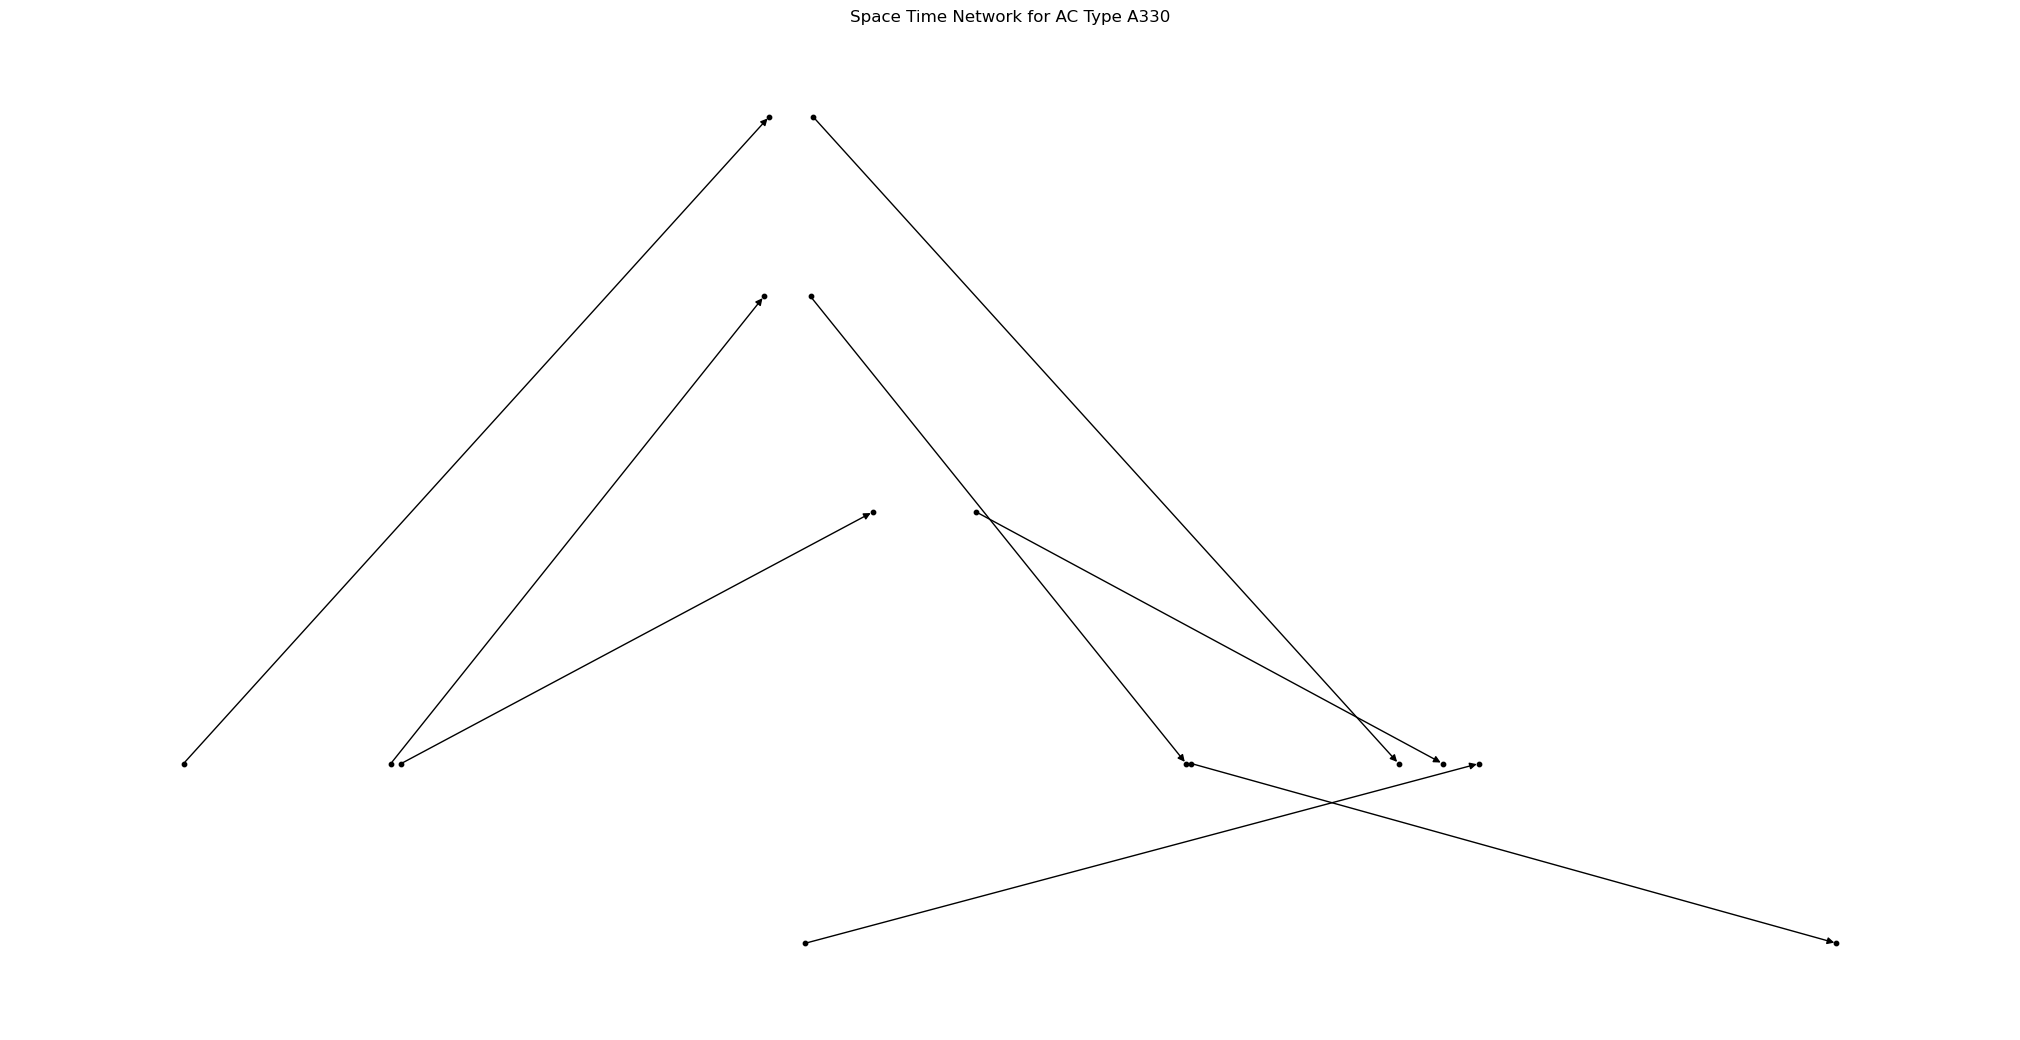

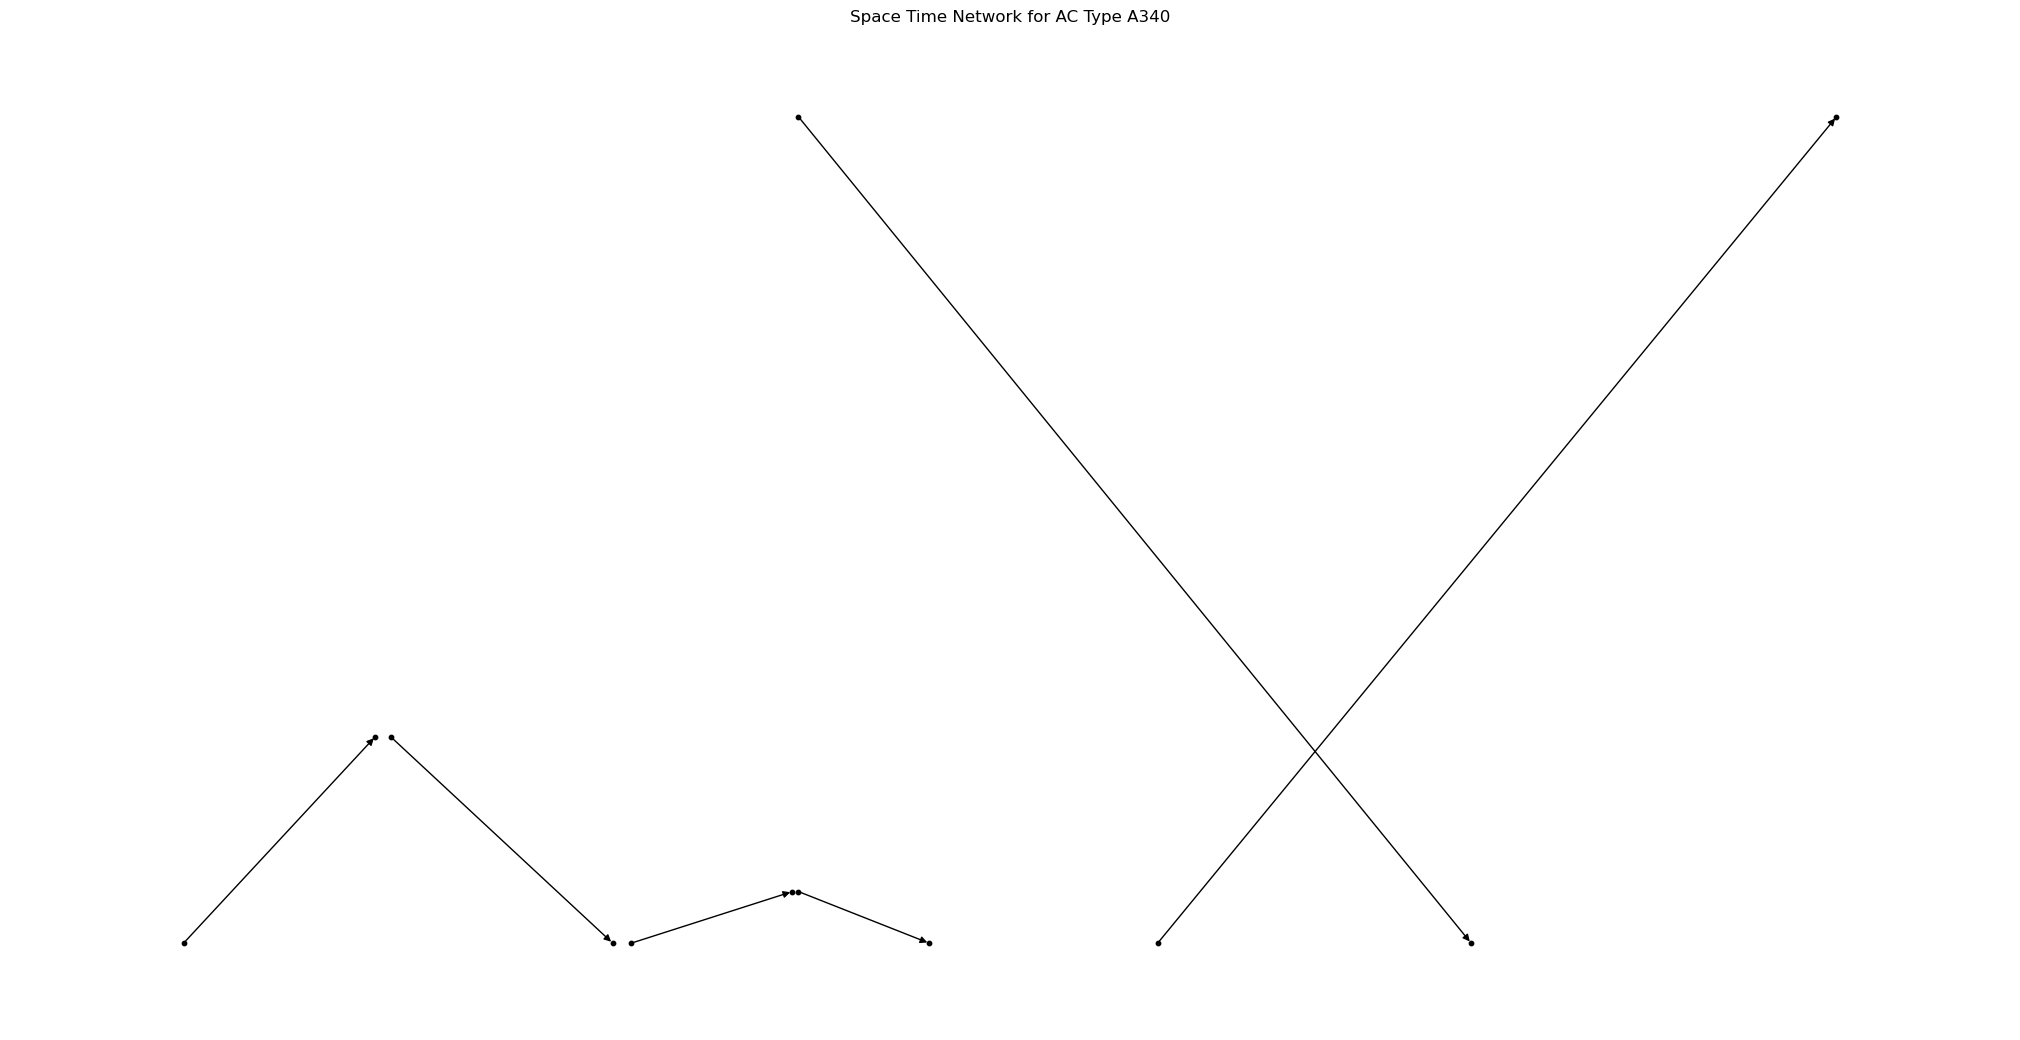

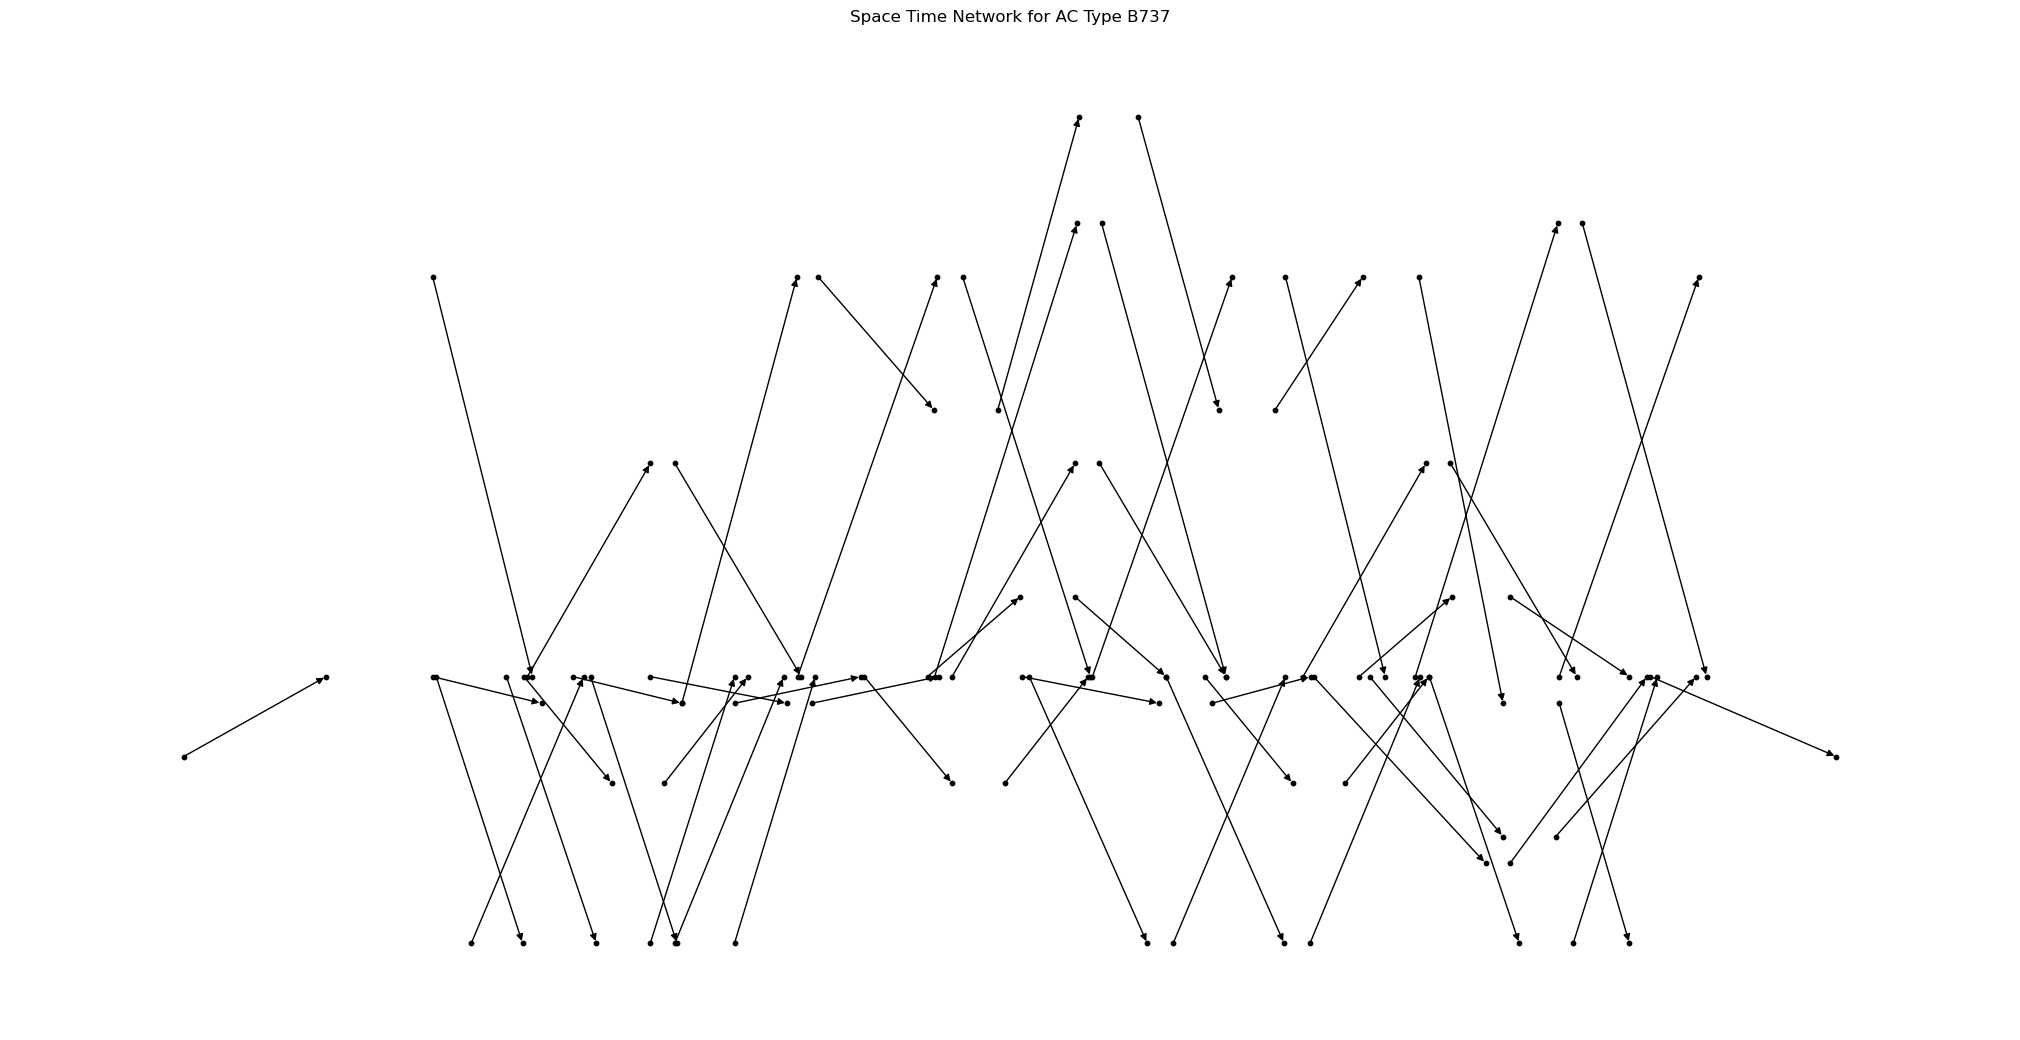

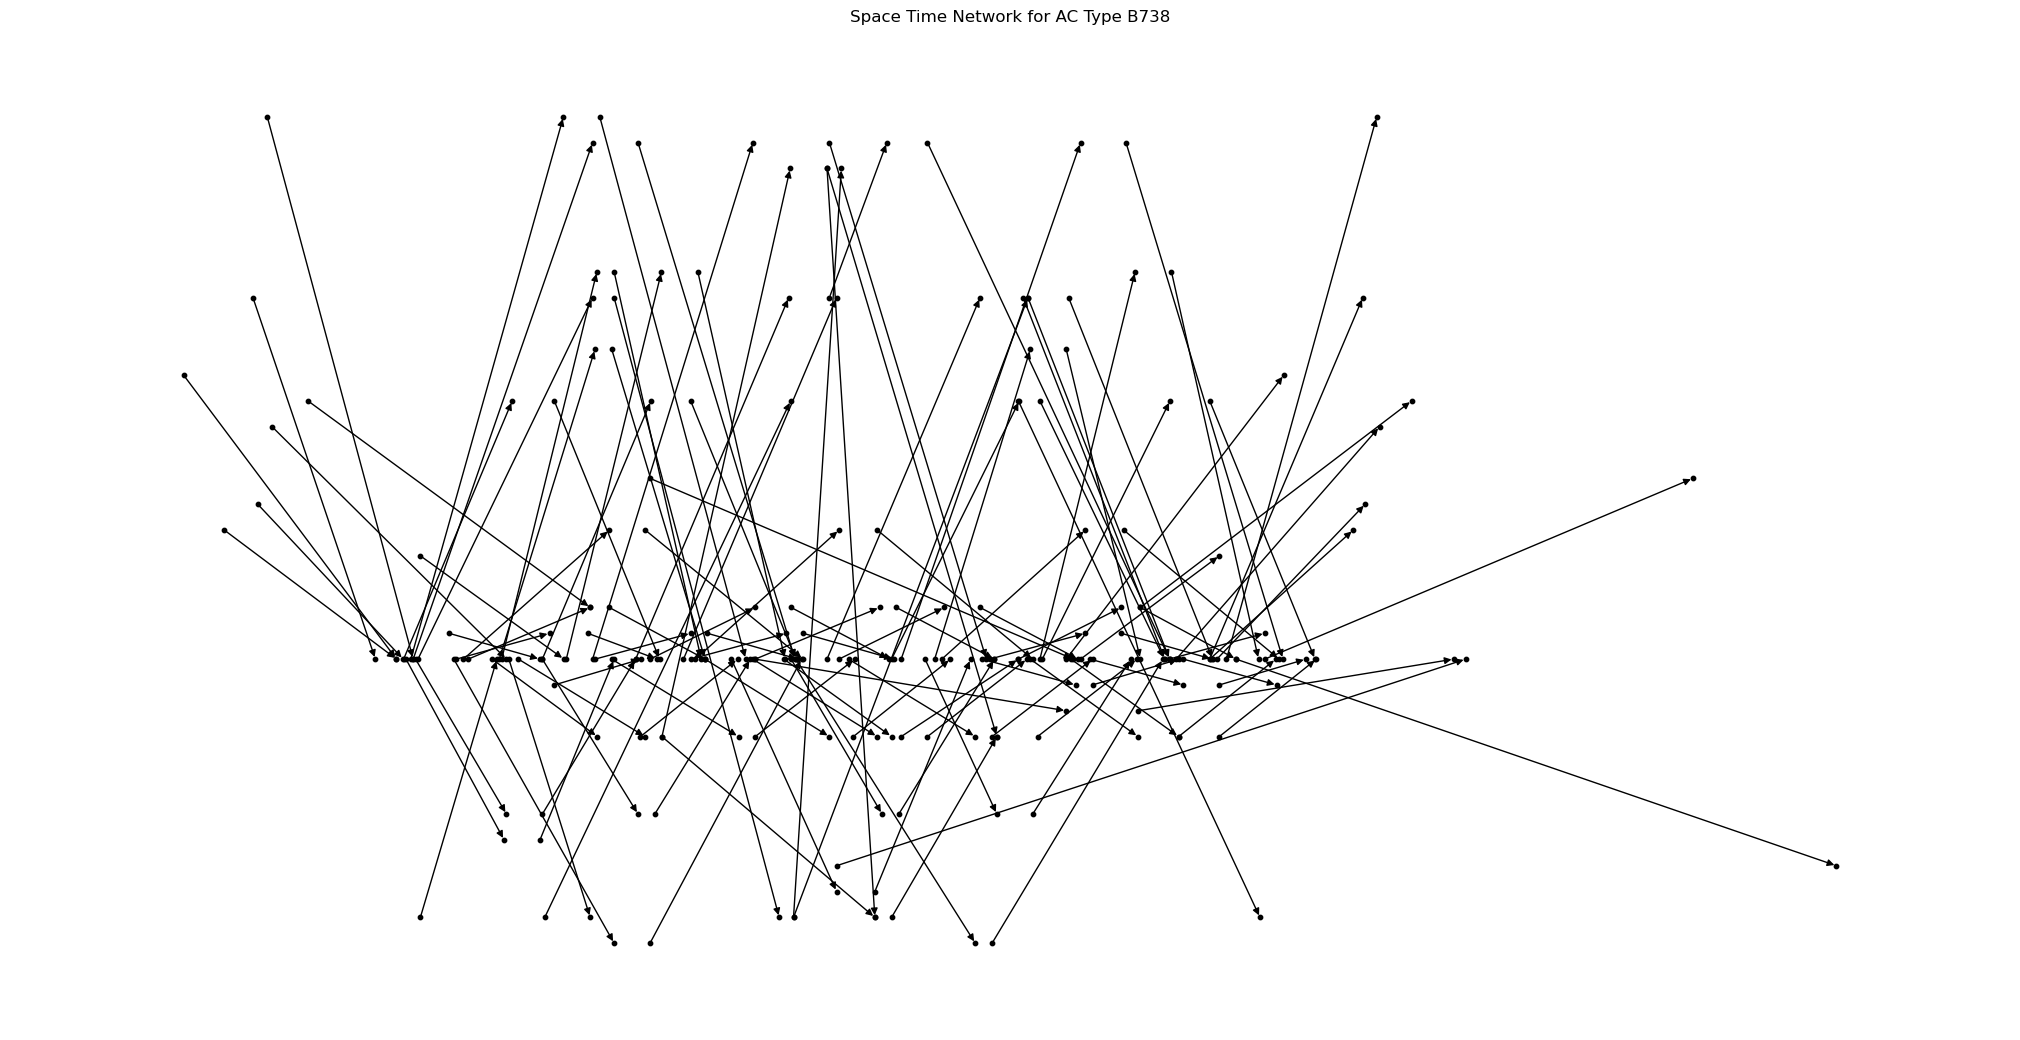

In [154]:
import networkx as nx
import plotly.graph_objects as go

# Create networkx a graph for each aircraft type
for k in ac_list:
    filtered_flights_ac = filtered_flights[filtered_flights['AC Type'] == k]
    ST = nx.DiGraph()

    # Add nodes from the filtered_flights_ac df where the x axis is the departure time and the y axis is the airport id
    for i in filtered_flights_ac.index:
        ST.add_node(str(i)+ filtered_flights_ac['Origin'][i], pos=(filtered_flights_ac['Departure_num'][i], filtered_flights_ac['Origin ID'][i]))
        ST.add_node(str(i)+ filtered_flights_ac['Destination'][i], pos=(filtered_flights_ac['Arrival_num'][i], filtered_flights_ac['Destination ID'][i]))

    # Add edges from the filtered_flights_ac df for each flight where the weight is the cost and it has a label with the ac type
    for i in filtered_flights_ac.index:
        ST.add_edge(str(i)+ filtered_flights_ac['Origin'][i], str(i)+ filtered_flights_ac['Destination'][i], weight=filtered_flights_ac['Cost'][i], label=filtered_flights_ac['Flight no.'][i])

    # Plot the graph
    plt.figure(figsize=(20,10))
    pos=nx.get_node_attributes(ST,'pos')
    nx.draw(ST, pos, with_labels=False, node_size=10, node_color='black')
    # labels = nx.get_edge_attributes(ST,'label')
    # nx.draw_networkx_edge_labels(ST,pos,edge_labels=labels)
    # add the airports and the time to the plot

    plt.title('Space Time Network for AC Type ' + k)
    plt.xlabel('Time')
    plt.ylabel('Airport ID')


    plt.show()


# NON RELAXED MODEL (FOR VERIFICATION)

In [155]:
# Notation

L = flights_list
P = paths
K = ac_list
G = nodes
N = airports
Q = Q_i
R = recapture_p

In [156]:
R_test = {}
# if a recapture rate exists for p,r then keep it else set it to 0
for p in P:
    for r in P:
        if (p,r) in R.keys():
            R_test[p,r] = R[(p,r)]
        else:
            R_test[p,r] = 0

In [157]:
# Define the model
m_u = gp.Model('IFAM')

# Notation
# P = paths with info on O, D, Demand, Fare, Legs
# L = flights_list
# P = initial_pairs
# K = ac_list
# G = nodes
# N = airports
# Q = Q_i
# R = recapture_p


# Decision variables from FAM
# f[i,k] binary 1 if flight arc i is assigned to aircraft type k, 0 otherwise
f = {}
# y_ak = integer number of aircraft of type k on the ground arc a
y = {}

for i in L:
    for k in K:
        f[i, k] = m_u.addVar(vtype=GRB.BINARY, name='f_' + str(i) + '_' + str(k))

for k in K:
    for a in list(ground_arcs[(ground_arcs['AC Type'] == k)]['Arc ID']):
        y[a, k] = m_u.addVar(vtype=GRB.INTEGER,lb=0, name='y_' + str(a) + '_' + str(k))

# Decision variables from PMF
# t_pr: number of passengers that would like to fly on itinerary p and are reallocated to itinerary r
t = {}

for p in P:
    for r in P:
        t[p,r] = m_u.addVar(vtype=GRB.CONTINUOUS,lb=0,name='t_'+str(p)+'_'+str(r))
m_u.update()

# Objective function part from the FAM
of = gp.quicksum(flights[i][k]['Cost'] * f[i,k] for i in L for k in K) + \
     gp.quicksum((P[p]['Fare'] - R_test[(p,r)] * P[r]['Fare']) * t[p,r] for p in P for r in P)

# Define the objective function
m_u.setObjective(of, GRB.MINIMIZE)

# Define the constraints from the FAM
# Constraint 1 [FAM]: 
# Each flight is assigned to exactly one aircraft type
m_u.addConstrs((gp.quicksum(f[i,k] for k in K) == 1 for i in L), name='one_ac')

# Constraint 2 [FAM]: 
# The number of AC arriving (n+ and arrivals) = AC departing yn-, for each type at each node
# y_n+_k + sum(f_i,k) = y_n-_k + sum(f_i,k)
for k in K:
    for n in N:
        for i in G[k][n]:
            n_plus = y[G[k][n][i]['n+'][0], k]
            n_minus = y[G[k][n][i]['n-'][0], k]
            departures = gp.quicksum(f[w,k] for w in G[k][n][i]['Departures'])
            arrivals = gp.quicksum(f[w,k] for w in G[k][n][i]['Arrivals'])
            m_u.addConstr((n_plus + departures - n_minus - arrivals == 0),
                         name='balance_' + str(i) + '_' + str(k) + '_' + str(n))

# Constraint 3 [FAM]: 
# The number of overnight arcs + the number of overnight flights = the number of aircraft of each type 
# using overnight_arcs and overnight_flights
# sum(y_a,k) + sum(f_i,k) = number of aircraft of type k
for k in K:
    m_u.addConstr((gp.quicksum(y[a, k] for a in list(overnight_arcs[(overnight_arcs['AC Type'] == k)]['Arc ID'])) + 
                 gp.quicksum(f[i, k] for i in list(overnight_flights[(overnight_flights['AC Type'] == k)]['Flight no.'])) <= 
                 aircraft[k]['Units']), name='overnight_' + str(k))

# Constraint 4 [MIXED]: 
# Aircraft capacity constraint
# sum seats_k * f_ik -sum s_ip * t_pr - sum sum s_ip * brp * t_rp >= ds_i for all i but for r = 0 
m_u.addConstrs((gp.quicksum(aircraft[k]['Seats'] * f[i,k] for k in K) +
              gp.quicksum(s_ip[i,p] * t[p,r] for p in P for r in P) - 
              gp.quicksum(s_ip[i,p] * R_test[(r,p)] * t[r,p] for p in P for r in P) >= 
              Q[i] for i in L), name='π')

# Constraint 5 [PMF]: sum t_pr <= Dp for all p
for p in P:
    m_u.addConstr((
        gp.quicksum(t[p,r] for r in P) <= paths[p]['Demand']), name='σ[' + str(p) + ']')

# Update the model
m_u.update()
# Optimize the model but dont print the output
m_u.setParam('OutputFlag', 1)
m_u.optimize()
print('Objective value: %0.0f' % (m_u.objVal/1000000))

KeyboardInterrupt: 

In [ ]:
print('Objective value: %0.0f' % (m_u.objVal))

In [ ]:
for w in ac_list:
    print('Flights for AC Type ' + w)
    for i in flights_list:
        for k in ac_list:
            if f[i,k].x > 0.1 and k == w:
                print(i," | ", round(f[i,k].x,ndigits=0)," | ", ('Cost = %0.3f' % (flights[i][k]['Cost'] * f[i,k].x / 1000)))
    print('\n')

# Count the non null values of f
total_flights = 0
for v in m.getVars():
    if v.x != 0 and v.varName[0] == 'f':
        total_flights += v.x
print('Total flights: ' + str(total_flights))
print(sum(f[i,k].x for i in flights for k in ac_list))
